# Solving the XOR Problem using MLP 

In this notebook we will create a small neural network to solve XOR problem using MLP

### Importing Libraries

In [1]:
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

random_seed = 123

In [2]:
# for this exercise we will consider cpu only

device = "cpu"
print(f"Using {device} device")

Using cpu device


### Read the dataset and plot

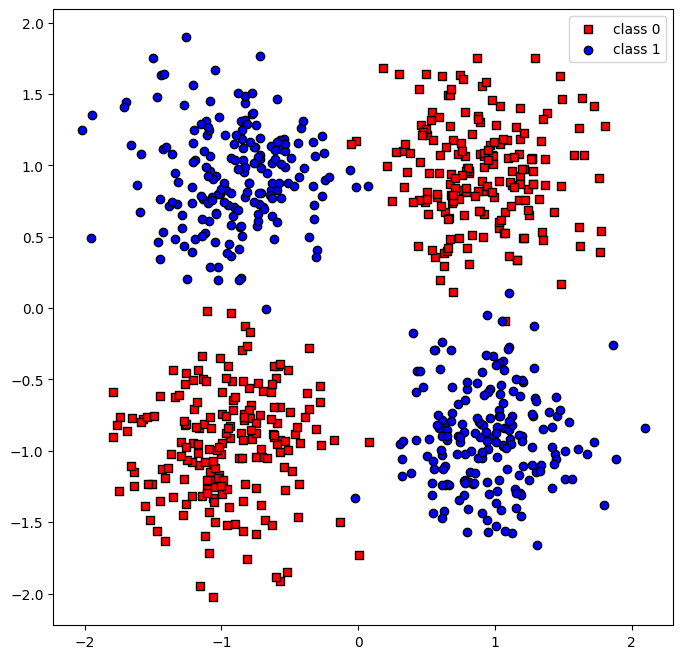

In [3]:
df = pd.read_csv('xor.csv')
X = df[['x1', 'x2']].values
y = df['class label'].values

plt.figure(figsize=(8,8))
plt.scatter(X[y==0, 0], X[y==0, 1], color='r', marker='s', edgecolors='k', label='class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], color='b', marker='o', edgecolors='k', label='class 1')
plt.legend()
plt.show()

### Can MLP with linear activations (i.e. no non-linear activation) solve the XOR problem?

In [12]:
class MLPLinear(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_classes):
        super(MLPLinear, self).__init__()
        
        self.num_classes = num_classes
        
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_1)
        self.linear_out = torch.nn.Linear(num_hidden_1, num_classes)
        
    def forward(self, x):
        
        out = self.linear_1(x)
        
        logits = self.linear_out(out)
        probas = F.sigmoid(logits)
        return logits, probas

In [14]:
torch.manual_seed(random_seed)

model1 = MLPLinear(num_features=2,
                   num_hidden_1=50,
                   num_classes=1)

model1 = model1.to(device)
print(model1)

optimizer = torch.optim.SGD(model1.parameters(), lr=0.1)

MLPLinear(
  (linear_1): Linear(in_features=2, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=50, bias=True)
  (linear_out): Linear(in_features=50, out_features=1, bias=True)
)


To form MLP with linear activation in the hidden layer, we haven't used any activation function after `out = self.linear_1(x)`

In [15]:
start_time = time.time()
cost_list = []

num_epochs = 25

features = torch.tensor(X, dtype=torch.float).to(device)
targets = torch.tensor(y, dtype=torch.float).to(device)

for epoch in range(num_epochs):

    ### Forward and Back Prop
    logits, probas = model1(features)

    cost = F.binary_cross_entropy_with_logits(logits, targets.view(-1,1))
    
    optimizer.zero_grad()

    cost.backward()
    
    cost_list.append(cost.item())

    ### Update model parameters
    optimizer.step()

    ### Logging
    print (f'Epoch: {epoch+1:03d}/{num_epochs:03d} | Cost: {cost:.4f}')

    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/025 | Cost: 0.7125
Epoch: 002/025 | Cost: 0.7046
Epoch: 003/025 | Cost: 0.6998
Epoch: 004/025 | Cost: 0.6970
Epoch: 005/025 | Cost: 0.6953
Epoch: 006/025 | Cost: 0.6943
Epoch: 007/025 | Cost: 0.6937
Epoch: 008/025 | Cost: 0.6933
Epoch: 009/025 | Cost: 0.6931
Epoch: 010/025 | Cost: 0.6929
Epoch: 011/025 | Cost: 0.6928
Epoch: 012/025 | Cost: 0.6928
Epoch: 013/025 | Cost: 0.6927
Epoch: 014/025 | Cost: 0.6927
Epoch: 015/025 | Cost: 0.6927
Epoch: 016/025 | Cost: 0.6927
Epoch: 017/025 | Cost: 0.6927
Epoch: 018/025 | Cost: 0.6927
Epoch: 019/025 | Cost: 0.6927
Epoch: 020/025 | Cost: 0.6927
Epoch: 021/025 | Cost: 0.6927
Epoch: 022/025 | Cost: 0.6927
Epoch: 023/025 | Cost: 0.6927
Epoch: 024/025 | Cost: 0.6927
Epoch: 025/025 | Cost: 0.6927
Total Training Time: 0.00 min


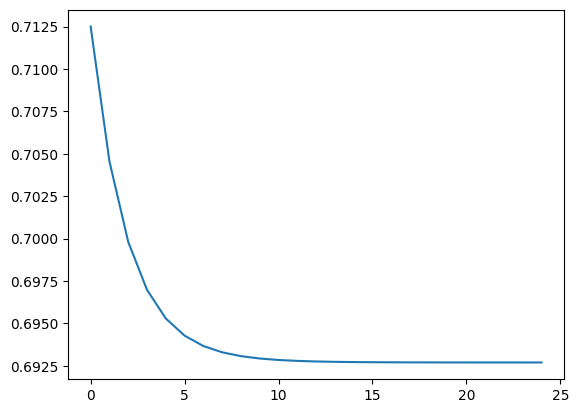

In [16]:
plt.plot(cost_list);

In [17]:
# Helper function to plot decision regions

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'o', 'x', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution, dtype=np.float32),
                           np.arange(x2_min, x2_max, resolution, dtype=np.float32),
                           copy=True)
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    logits, probas = classifier.forward(tensor)
    Z = probas.detach().numpy()
    Z = (Z >= 0.5).astype(int)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    color=cmap(idx),
                    edgecolor='k',
                    marker=markers[idx], 
                    label=cl)

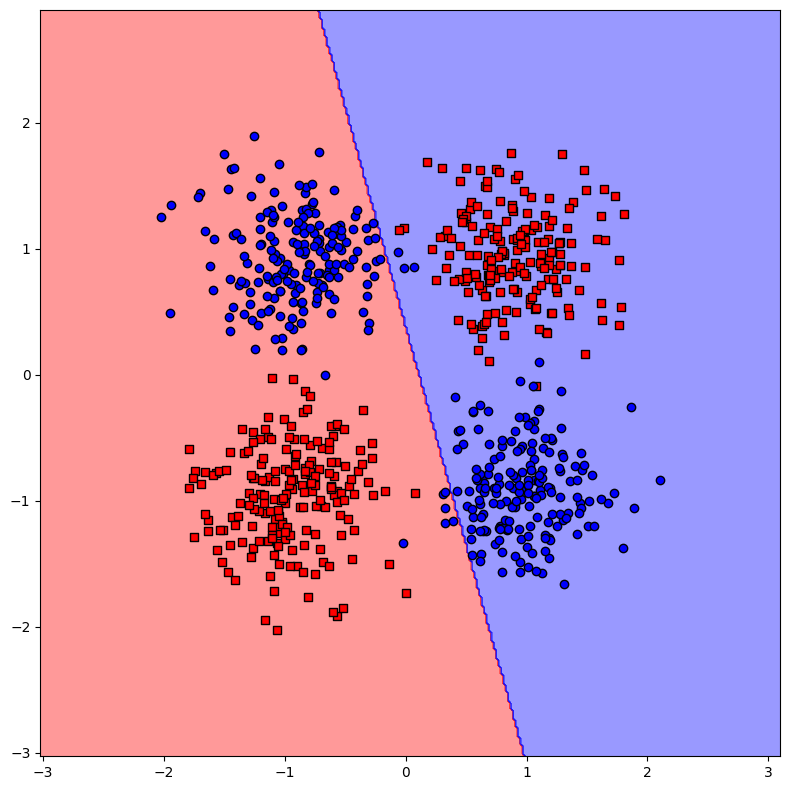

In [18]:
plt.figure(figsize=(8,8))
plot_decision_regions(features, targets, classifier=model1)

plt.tight_layout()
plt.show()

So, despite having an hidden layer the MLP failed to classify this problem because there is no non-linear activation function.

### Multilayer Perceptron with Non-Linear Activations (Here: ReLU)

In [28]:
class MLPReLU(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_classes):
        super(MLPReLU, self).__init__()
        
        self.num_classes = num_classes
        
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_out = torch.nn.Linear(num_hidden_1, num_classes)
        
    def forward(self, x):
        
        out = self.linear_1(x)
        out = F.relu(out)
        
        logits = self.linear_out(out)
        probas = F.sigmoid(logits)
        return logits, probas

In [29]:
torch.manual_seed(random_seed)

model2 = MLPReLU(num_features=2,
                   num_hidden_1=50,
                   num_classes=1)

model2 = model2.to(device)
print(model2)

optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

MLPReLU(
  (linear_1): Linear(in_features=2, out_features=50, bias=True)
  (linear_out): Linear(in_features=50, out_features=1, bias=True)
)


In [30]:
start_time = time.time()
cost_list = []

num_epochs = 50

features = torch.tensor(X, dtype=torch.float).to(device)
targets = torch.tensor(y, dtype=torch.float).to(device)

for epoch in range(num_epochs):

    ### Forward and Back Prop
    logits, probas = model2(features)

    cost = F.binary_cross_entropy_with_logits(logits, targets.view(-1,1))
    optimizer.zero_grad()

    cost.backward()
    cost_list.append(cost.item())

    ### Update model parameters
    optimizer.step()

    ### Logging
    print (f'Epoch: {epoch+1:03d}/{num_epochs:03d} | Cost: {cost:.4f}')

    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Cost: 0.6748
Epoch: 002/050 | Cost: 0.6616
Epoch: 003/050 | Cost: 0.6491
Epoch: 004/050 | Cost: 0.6371
Epoch: 005/050 | Cost: 0.6255
Epoch: 006/050 | Cost: 0.6145
Epoch: 007/050 | Cost: 0.6038
Epoch: 008/050 | Cost: 0.5934
Epoch: 009/050 | Cost: 0.5834
Epoch: 010/050 | Cost: 0.5737
Epoch: 011/050 | Cost: 0.5643
Epoch: 012/050 | Cost: 0.5551
Epoch: 013/050 | Cost: 0.5461
Epoch: 014/050 | Cost: 0.5374
Epoch: 015/050 | Cost: 0.5288
Epoch: 016/050 | Cost: 0.5205
Epoch: 017/050 | Cost: 0.5123
Epoch: 018/050 | Cost: 0.5043
Epoch: 019/050 | Cost: 0.4964
Epoch: 020/050 | Cost: 0.4887
Epoch: 021/050 | Cost: 0.4812
Epoch: 022/050 | Cost: 0.4738
Epoch: 023/050 | Cost: 0.4665
Epoch: 024/050 | Cost: 0.4593
Epoch: 025/050 | Cost: 0.4523
Epoch: 026/050 | Cost: 0.4454
Epoch: 027/050 | Cost: 0.4386
Epoch: 028/050 | Cost: 0.4319
Epoch: 029/050 | Cost: 0.4253
Epoch: 030/050 | Cost: 0.4189
Epoch: 031/050 | Cost: 0.4125
Epoch: 032/050 | Cost: 0.4063
Epoch: 033/050 | Cost: 0.4002
Epoch: 034

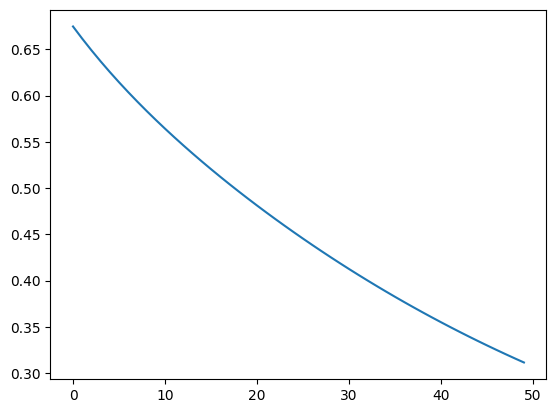

In [31]:
plt.plot(cost_list);

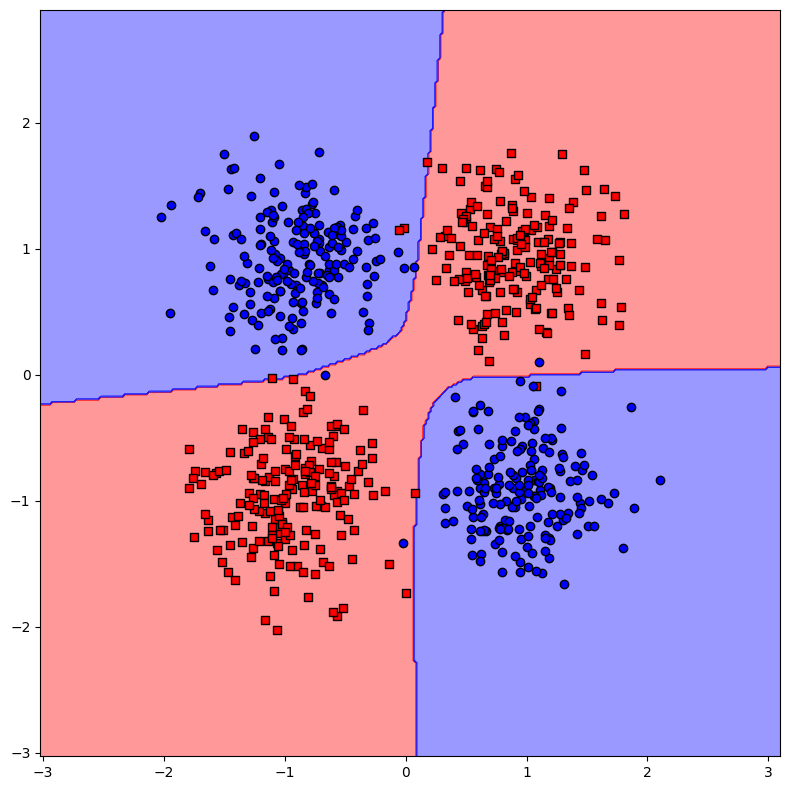

In [32]:
plt.figure(figsize=(8,8))

plot_decision_regions(features, targets, classifier=model2)

plt.tight_layout()

plt.show()